# Project: Developer Salary Analysis (CRISP-DM)

## Business Understanding
The goal of this project is to analyze the 2023 Stack Overflow Developer Survey data to understand the key factors that influence developer salaries. 

### Research Questions:
1. **Experience:** How much does an additional year of coding experience increase expected salary?
2. **Education:** Does having a Master's degree provide a significant salary boost compared to a Bachelor's degree?
3. **Environment:** What is the salary premium associated with Remote work compared to In-person roles?

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_raw = pd.read_csv('Data/survey_results_public.csv')

columns_of_interest = ['ConvertedCompYearly', 'YearsCode', 'EdLevel', 'RemoteWork', 'Country']
df = df_raw[columns_of_interest].copy()

df.rename(columns={'ConvertedCompYearly': 'Salary'}, inplace=True)

print(f"Initial dataset shape: {df.shape}")
print(df.info())

Initial dataset shape: (65437, 5)
<class 'pandas.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Salary      23435 non-null  float64
 1   YearsCode   59869 non-null  str    
 2   EdLevel     60784 non-null  str    
 3   RemoteWork  54806 non-null  str    
 4   Country     58930 non-null  str    
dtypes: float64(1), str(4)
memory usage: 2.5 MB
None


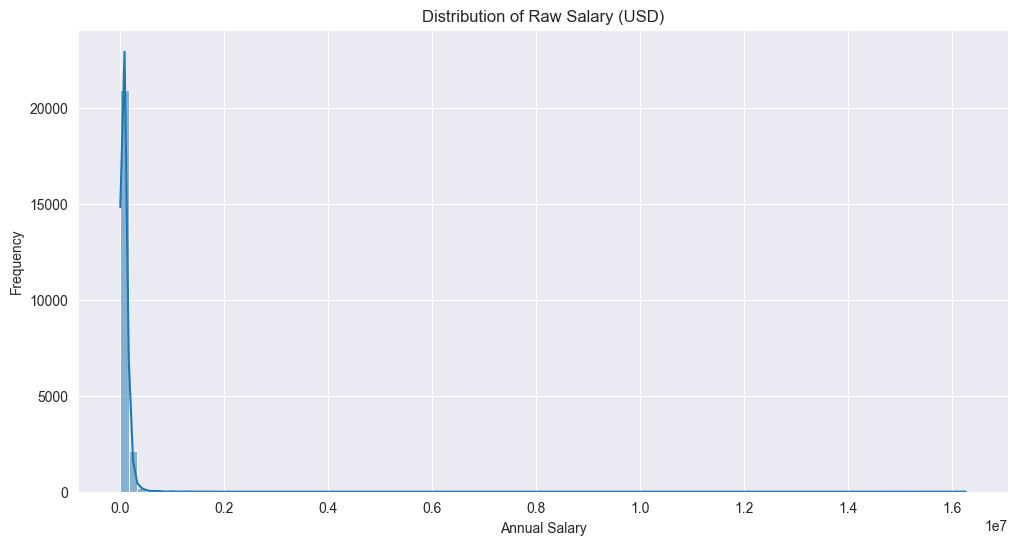

Maximum Salary in dataset: $16,256,603.00
Minimum Salary in dataset: $1.00


In [12]:
# Create a histogram of the raw salary data
plt.figure(figsize=(12, 6))
sns.histplot(df['Salary'], bins=100, kde=True)
plt.title('Distribution of Raw Salary (USD)')
plt.xlabel('Annual Salary')
plt.ylabel('Frequency')
plt.show()

print(f"Maximum Salary in dataset: ${df['Salary'].max():,.2f}")
print(f"Minimum Salary in dataset: ${df['Salary'].min():,.2f}")

I have identified several issues that must be addressed before the data is suitable for modeling:

* **Extreme Outliers:** The histogram reveals a heavily "long-tailed" distribution. While most developers earn under $250,000, there are extreme values reaching up to $5,000,000. These outliers will disproportionately influence a Linear Regression model, leading to poor predictive accuracy.
* **Missing Values (NaNs):** A significant portion of the `Salary` and `YearsCode` columns contain missing data. Since `Salary` is our target variable, we cannot impute these values without introducing significant bias.
* **Non-Numeric Data:** The `YearsCode` column is currently stored as text (object) because it contains categorical strings like "Less than 1 year" and "More than 50 years."

**Next Steps (Data Preparation):**
1.  **Filter Outliers:** I will restrict the dataset to a "professional range" of $20,000 to $250,000 to ensure the model focuses on the core developer population.
2.  **Drop Nulls:** I will remove rows with missing values in our key features to maintain data integrity.

In [13]:
df['Is_USA'] = df['Country'].apply(lambda x: 1 if x == 'United States of America' else 0)
df = df.drop(columns=['Country'])

df = df[(df['Salary'] >= 20000) & (df['Salary'] <= 250000)]

df = df.dropna(subset=['Salary', 'YearsCode', 'EdLevel', 'RemoteWork'])

def clean_years_code(years_value):
    """
    Standardizes the 'YearsCode' column by converting strings to floats.
    """
    if years_value == 'More than 50 years':
        return 50.0
    if years_value == 'Less than 1 year':
        return 0.5
    try:
        return float(years_value)
    except (ValueError, TypeError):
        return np.nan

df['YearsCode'] = df['YearsCode'].apply(clean_years_code)

df = df.dropna(subset=['YearsCode'])

print(f"Final Cleaned Dataset Shape: {df.shape}")
df.head()

Final Cleaned Dataset Shape: (18868, 5)


,Salary,YearsCode,EdLevel,RemoteWork,Is_USA
374,30074.0,12.0,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)","Hybrid (some remote, some in-person)",0
379,91295.0,15.0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Remote,0
385,53703.0,27.0,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Remote,0
389,110000.0,7.0,Some college/university study without earning ...,Remote,1
392,161044.0,32.0,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)","Hybrid (some remote, some in-person)",0


In [14]:
df = df[df['EdLevel'].str.contains('Bachelor’s degree|Master’s degree', na=False)]
df['EdLevel'] = df['EdLevel'].apply(lambda x: 'Masters' if 'Master’s degree' in x else 'Bachelors')

df['RemoteWork'] = df['RemoteWork'].replace({
    'Remote': 'Remote',
    'Hybrid (some remote, some in-person)': 'Hybrid',
    'In-person': 'In-person'
})

print("Final Education Distribution:")
print(df['EdLevel'].value_counts())
print("\nFinal Remote Work Distribution:")
print(df['RemoteWork'].value_counts())

df.head()

Final Education Distribution:
EdLevel
Bachelors    8121
Masters      5834
Name: count, dtype: int64

Final Remote Work Distribution:
RemoteWork
Hybrid       6292
Remote       5725
In-person    1938
Name: count, dtype: int64


,Salary,YearsCode,EdLevel,RemoteWork,Is_USA
379,91295.0,15.0,Masters,Remote,0
385,53703.0,27.0,Masters,Remote,0
395,121018.0,32.0,Masters,Remote,0
414,184712.0,30.0,Bachelors,Remote,0
415,79481.0,21.0,Masters,Remote,0


## Final Data Preparation Summary

The cleaning and manipulation phase is now complete.
### Feature Summary:
* **`Salary`:** Filtered to a range of $20,000 to $250,000.
* **`YearsCode`:** Transformed from a string-based survey response into a continuous numeric `float`.
* **`Is_USA`:** A binary feature engineered from the original 'Country' column. This simplifies the model while capturing the significant salary difference between the United States and other global markets.
* **`RemoteWork`:** Standardized into three clean categories: **Remote**, **Hybrid**, and **In-person**. This will allow us to quantify the "Remote Premium" or "In-person Discount."
* **`EdLevel`:** Refined to a head-to-head comparison between **Bachelors** and **Masters** degree holders, directly addressing our research question regarding the ROI of a higher degree.

### Data Integrity:
I have removed all missing values (NaNs) from these specific features, ensuring that the final model trains on a complete and verified dataset. The result is a high-quality CSV file ready for statistical modeling and visualization.

In [16]:
df.to_csv('Data/cleanData.csv', index=False)
print(f"Final row count for analysis: {df.shape[0]}")

Final row count for analysis: 13955


C:\Users\Ihimo\AppData\Local\Temp\ipykernel_1820\916558773.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], data=df, x='EdLevel', y='Salary', palette='Set2')
C:\Users\Ihimo\AppData\Local\Temp\ipykernel_1820\916558773.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2], data=df, x='RemoteWork', y='Salary', palette='Set3')


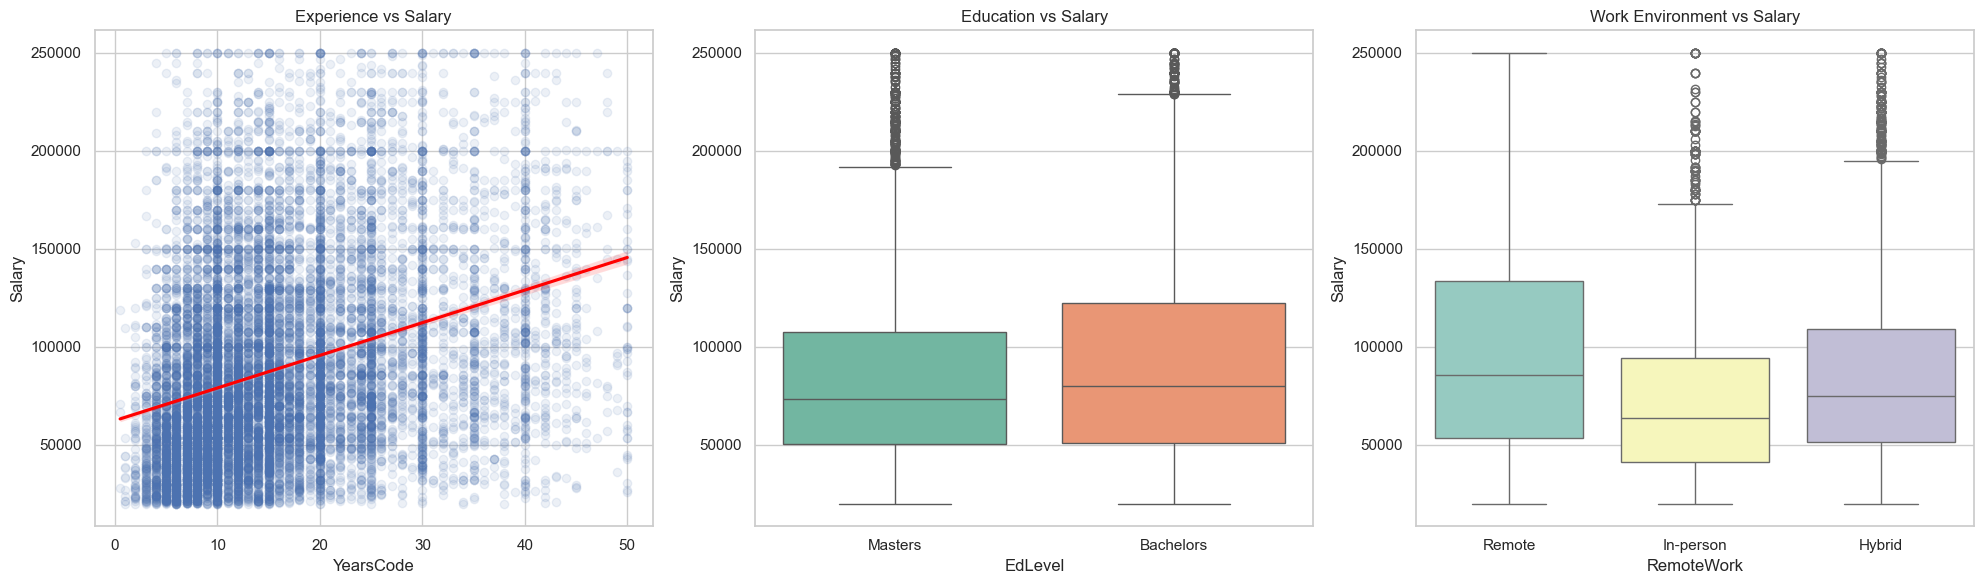

In [17]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.regplot(ax=axes[0], data=df, x='YearsCode', y='Salary', 
            scatter_kws={'alpha':0.1}, line_kws={"color": "red"})
axes[0].set_title('Experience vs Salary')

sns.boxplot(ax=axes[1], data=df, x='EdLevel', y='Salary', palette='Set2')
axes[1].set_title('Education vs Salary')

sns.boxplot(ax=axes[2], data=df, x='RemoteWork', y='Salary', palette='Set3')
axes[2].set_title('Work Environment vs Salary')

plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA) Insights


* **Experience:** The regression plot confirms a positive relationship between years of coding and salary. While there is significant variance, the trend line suggests a steady increase in earning potential over time.
* **Education:** A comparison between Bachelor's and Master's degrees shows surprisingly similar median salaries. This initial look suggests that for software developers, the specific degree level (between these two) might have less impact on salary than other factors like experience.
* **Remote Work:** The boxplots indicate a clear "Remote Premium." Developers working remotely show a higher median salary than those working in-person or in hybrid roles, which aligns with modern industry trends favoring flexible, high-paying tech roles.

These insights justify my decision to move forward with a Linear Regression model to quantify exactly how much each of these factors contributes to a developer's salary.